## Importing Modules

In [11]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.figure as figure
import seaborn as sns
import statsmodels.api as sm
from statsmodels.distributions.empirical_distribution import ECDF
from pandas.core import datetools
import datetime as dt
from scipy.stats import pearsonr

In [37]:
nohitters = pd.read_csv("mlb_nohitters.csv")

In [63]:
Micheal = pd.read_csv("michelson_speed_of_light.csv")

In [38]:
nohitters.head()

,date,game_number,winning_team,losing_team,winning_pitcher
0,18760715,140,NaN,NaN,NaN
1,18800612,1035,NaN,NaN,NaN
2,18800617,1046,NaN,NaN,NaN
3,18800819,1177,NaN,NaN,NaN
4,18800820,1179,NaN,NaN,NaN


In [39]:
df = pd.read_csv("female_literacy_fertility.csv")

In [40]:
df.head()

,Country,Continent,female literacy,fertility,population
0,Chine,ASI,90.5,1.769,"1,324,655,000"
1,Inde,ASI,50.8,2.682,"1,139,964,932"
2,USA,NAM,99.0,2.077,"304,060,000"
3,Indonésie,ASI,88.8,2.132,"227,345,082"
4,Brésil,LAT,90.2,1.827,"191,971,506"


## EDA of litracy/fertility data

we will look at the correlation between female literacy and fertility (defined as the average number of children born per woman) throughout the world. For ease of analysis and interpretation, we will work with the illiteracy rate.

It is always a good idea to do some EDA ahead of our analysis. To this end, plot the fertility versus illiteracy and compute the Pearson correlation coefficient. The Numpy array illiteracy has the illiteracy rate among females for most of the world's nations. The array fertility has the corresponding fertility data.


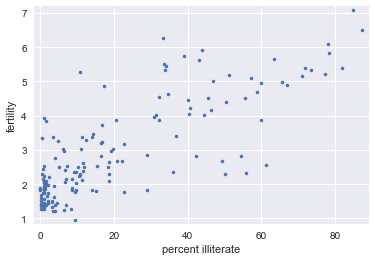

(-0.80413240268153452, 5.6350929859765588e-38)


In [41]:
illitracy = 100 - df[['female literacy']]
fertility = df[['fertility']]

# Plot the illiteracy rate versus fertility
plt.plot(illitracy, fertility, marker='.', linestyle='none')

# Set the margins and label axes
plt.margins(0.02)
plt.xlabel('percent illiterate')
plt.ylabel('fertility')

# Show the plot
plt.show()

# Show the Pearson correlation coefficient
print(pearsonr(df['female literacy'], df['fertility']))


In [43]:
df['illiteracy'] = illitracy

### 
You can see the correlation between illiteracy and fertility by eye, and by the substantial Pearson correlation coefficient of 0.8. It is difficult to resolve in the scatter plot, but there are many points around near-zero illiteracy and about 1.8 children/woman.

## Linear regression

We will assume that fertility is a linear function of the female illiteracy rate. That is, f=ai+b, where a is the slope and b is the intercept. We can think of the intercept as the minimal fertility rate, probably somewhere between one and two. The slope tells us how the fertility rate varies with illiteracy. We can find the best fit line using np.polyfit().

Plot the data and the best fit line. Print out the slope and intercept. (Think: what are their units?)

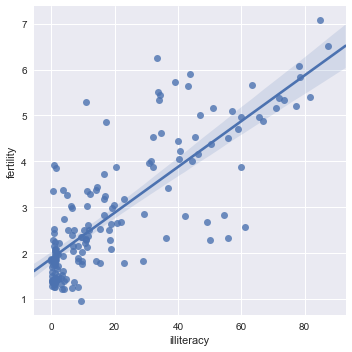

In [44]:
sns.lmplot(data=df,
           x='illiteracy',
           y='fertility')
plt.show()

slope = 0.0497985480906 children per woman / percent illiterate
intercept = 1.88805061064 children per woman


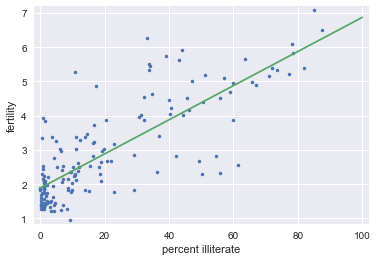

In [45]:
# Plot the illiteracy rate versus fertility
plt.plot(illiteracy, fertility, marker='.', linestyle='none')
plt.margins(0.02)
plt.xlabel('percent illiterate')
plt.ylabel('fertility')

# Perform a linear regression using np.polyfit(): a, b
a, b = np.polyfit(df['illiteracy'], df['fertility'], 1)

# Print the results to the screen
print('slope =', a, 'children per woman / percent illiterate')
print('intercept =', b, 'children per woman')

# Make theoretical line to plot
x = np.array([0, 100])
y = a * x + b

# Add regression line to your plot
plt.plot(x, y)

# Draw the plot
plt.show()

## How is it optimal?

The function np.polyfit() that you used to get your regression parameters finds the optimal slope and intercept. It is optimizing the sum of the squares of the residuals, also known as RSS (for residual sum of squares). 

plot the function that is being optimized, the RSS, versus the slope parameter a. To do this, fix the intercept to be what you found in the optimization. Then, plot the RSS vs. the slope. Where is it minimal?

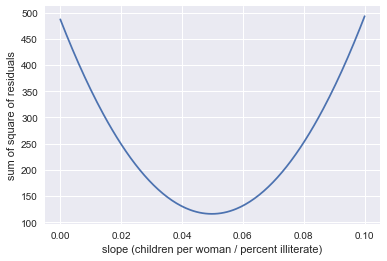

In [46]:
# Specify slopes to consider: a_vals
a_vals = np.linspace(0, 0.1, 200)

# Initialize sum of square of residuals: rss
rss = np.empty_like(a_vals)

# Compute sum of square of residuals for each value of a_vals
for i, a in enumerate(a_vals):
    rss[i] = np.sum((df['fertility'] - a*df['illiteracy'] - b)**2)

# Plot the RSS
plt.plot(a_vals, rss, '-')
plt.xlabel('slope (children per woman / percent illiterate)')
plt.ylabel('sum of square of residuals')

plt.show()


## Generating bootstrap replicates

### Visualizing bootsrap samples

you will generate bootstrap samples from the set of annual rainfall data measured at the Sheffield Weather Station in the UK from 1883 to 2015. The data are stored in the NumPy array rainfall in units of millimeters (mm).

By graphically displaying the bootstrap samples with an ECDF, you can get a feel for how bootstrap sampling allows probabilistic descriptions of data.

In [55]:
weather = pd.read_csv("sheffield_weather_station.csv",sep='delimiter', header=None)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [53]:
weather.head()

,0
0,yyyy mm tmax tmin af rain sun
1,1883 1 6.3 1.7 6 122.1 ---
2,1883 2 8.0 2.8 2 69.8 ---
3,1883 3 4.8 -1.6 23 29.6 ---
4,1883 4 12.2 3.8 2 74.0 ---


In [56]:
rainfall = np.array( [875.5,   648.2,   788.1,   940.3,   491.1,   743.5,   730.1,
         686.5,   878.8,   865.6,   654.9,   831.5,   798.1,   681.8,
         743.8,   689.1,   752.1,   837.2,   710.6,   749.2,   967.1,
         701.2,   619. ,   747.6,   803.4,   645.6,   804.1,   787.4,
         646.8,   997.1,   774. ,   734.5,   835. ,   840.7,   659.6,
         828.3,   909.7,   856.9,   578.3,   904.2,   883.9,   740.1,
         773.9,   741.4,   866.8,   871.1,   712.5,   919.2,   927.9,
         809.4,   633.8,   626.8,   871.3,   774.3,   898.8,   789.6,
         936.3,   765.4,   882.1,   681.1,   661.3,   847.9,   683.9,
         985.7,   771.1,   736.6,   713.2,   774.5,   937.7,   694.5,
         598.2,   983.8,   700.2,   901.3,   733.5,   964.4,   609.3,
        1035.2,   718. ,   688.6,   736.8,   643.3,  1038.5,   969. ,
         802.7,   876.6,   944.7,   786.6,   770.4,   808.6,   761.3,
         774.2,   559.3,   674.2,   883.6,   823.9,   960.4,   877.8,
         940.6,   831.8,   906.2,   866.5,   674.1,   998.1,   789.3,
         915. ,   737.1,   763. ,   666.7,   824.5,   913.8,   905.1,
         667.8,   747.4,   784.7,   925.4,   880.2,  1086.9,   764.4,
        1050.1,   595.2,   855.2,   726.9,   785.2,   948.8,   970.6,
         896. ,   618.4,   572.4,  1146.4,   728.2,   864.2,   793. ])

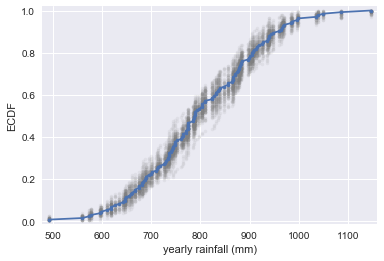

In [61]:
for _ in range(50):
    # Generate bootstrap sample: bs_sample
    bs_sample = np.random.choice(rainfall, size=len(rainfall))

    # Compute and plot ECDF from bootstrap sample
    x, y = ecdf(bs_sample)
    _ = plt.plot(x, y, marker='.', linestyle='none',
                 color='gray', alpha=0.1)

# Compute and plot ECDF from original data
x, y = ecdf(rainfall)
_ = plt.plot(x, y, marker='.')

# Make margins and label axes
plt.margins(0.02)
_ = plt.xlabel('yearly rainfall (mm)')
_ = plt.ylabel('ECDF')

# Show the plot
plt.show()

## Bootstrap replicates function

In [62]:
def bootstrap_replicate_1d(data, func):
    """Generate bootstrap replicate of 1D data."""
    bs_sample = np.random.choice(data, len(data))
    return func(bs_sample)

In [65]:
bootstrap_replicate_1d(Micheal['velocity of light in air (km/s)'],np.mean)

299860.0

In [66]:
bootstrap_replicate_1d(Micheal['velocity of light in air (km/s)'],np.std)

75.807321546140912

### Many bootstrap replicates

In [67]:
bs_replicates = np.empty(10000)

for i in range(10000):
    bs_replicates[i] = bootstrap_replicate_1d(Micheal['velocity of light in air (km/s)'],np.mean)

## Plotting a histogram of bootstrap replicates 

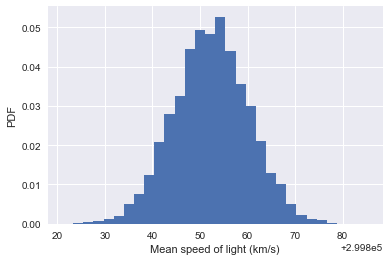

In [68]:
plt.hist(bs_replicates, bins=30, normed=True)
plt.xlabel('Mean speed of light (km/s)')
plt.ylabel('PDF')
plt.show()

## Confidence interval of statistic

1. If we repeateed measrements over and over again p% of the observed values would lie within the p% confidence initerval.

In [70]:
# Bootstrap confidence interval
conf_int = np.percentile(bs_replicates,[2.5,97.5])
print(conf_int)

[ 299836.8975  299867.7   ]


## Bootstrap replicates of the mean and the SEM

bootstrap estimate of the probability density function of the mean annual rainfall at the Sheffield Weather Station. Remember, we are estimating the mean annual rainfall we would get if the Sheffield Weather Station could repeat all of the measurements from 1883 to 2015 over and over again.

This is a probabilistic estimate of the mean. You will plot the PDF as a histogram, and you will see that it is Normal.

n fact, it can be shown theoretically that under not-too-restrictive conditions, the value of the mean will always be Normally distributed. (This does not hold in general, just for the mean and a few other statistics.) 

The standard deviation of this distribution, called the standard error of the mean, or SEM, is given by the standard deviation of the data divided by the square root of the number of data points. I.e., for a data set, sem = np.std(data) / np.sqrt(len(data)). 

Using hacker statistics, you get this same result without the need to derive it, but you will verify this result from your bootstrap replicates.


10.5105491505
10.5128084386


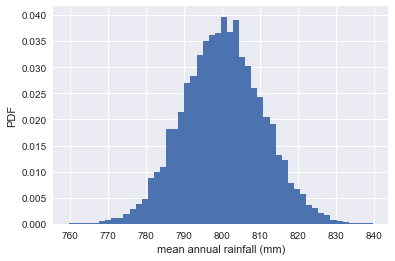

In [72]:
def draw_bs_reps(data, func, size=1):
    return np.array([bootstrap_replicate_1d(data, func) for _ in range(size)])

# Take 10,000 bootstrap replicates of the mean: bs_replicates
bs_replicates = draw_bs_reps(rainfall,np.mean,10000)

# Compute and print SEM
sem = np.std(rainfall) / np.sqrt(len(rainfall))
print(sem)

# Compute and print standard deviation of bootstrap replicates
bs_std = np.std(bs_replicates)
print(bs_std)

# Make a histogram of the results
plt.hist(bs_replicates, bins=50, normed=True)
plt.xlabel('mean annual rainfall (mm)')
plt.ylabel('PDF')

# Show the plot
plt.show()

## Confidence intervals of rainfall data

A confidence interval gives upper and lower bounds on the range of parameter values you might expect to get if we repeat our measurements. For named distributions, you can compute them analytically or look them up, but one of the many beautiful properties of the bootstrap method is that you can take percentiles of your bootstrap replicates to get your confidence interval. Conveniently, you can use the np.percentile() function.

Use the bootstrap replicates you just generated to compute the 95% confidence interval. That is, give the 2.5th and 97.5th percentile of your bootstrap replicates stored as bs_replicates. What is the 95% confidence interval?

Ans= (780, 821) mm/year

## Bootstrap replicates of other statistics

We saw that the mean is Normally distributed. This does not necessarily hold for other statistics, but no worry: as hackers, we can always take bootstrap replicates! In this exercise, you'll generate bootstrap replicates for the variance of the annual rainfall at the Sheffield Weather Station and plot the histogram of the replicates.


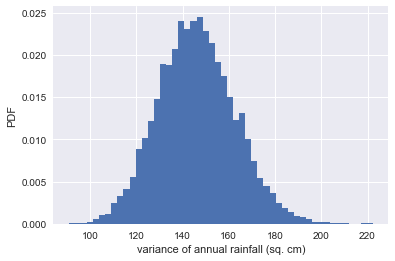

In [73]:
def draw_bs_reps(data, func, size=1):
    return np.array([bootstrap_replicate_1d(data, func) for _ in range(size)])
# Generate 10,000 bootstrap replicates of the variance: bs_replicates
bs_replicates = draw_bs_reps(rainfall, np.var, size=10000)

# Put the variance in units of square centimeters
bs_replicates /= 100

# Make a histogram of the results
plt.hist(bs_replicates, bins=50, normed=True)
plt.xlabel('variance of annual rainfall (sq. cm)')
plt.ylabel('PDF')

# Show the plot
plt.show()

# Show the plot
plt.show()


## confidence interval on the rate of no hitters

Consider again the inter-no-hitter intervals for the modern era of baseball. Generate 10,000 bootstrap replicates of the optimal parameter τ. Plot a histogram of your replicates and report a 95% confidence interval.

In [75]:
nohitter_times = np.array([ 843, 1613, 1101,  215,  684,  814,  278,  324,  161,  219,  545,
        715,  966,  624,   29,  450,  107,   20,   91, 1325,  124, 1468,
        104, 1309,  429,   62, 1878, 1104,  123,  251,   93,  188,  983,
        166,   96,  702,   23,  524,   26,  299,   59,   39,   12,    2,
        308, 1114,  813,  887,  645, 2088,   42, 2090,   11,  886, 1665,
       1084, 2900, 2432,  750, 4021, 1070, 1765, 1322,   26,  548, 1525,
         77, 2181, 2752,  127, 2147,  211,   41, 1575,  151,  479,  697,
        557, 2267,  542,  392,   73,  603,  233,  255,  528,  397, 1529,
       1023, 1194,  462,  583,   37,  943,  996,  480, 1497,  717,  224,
        219, 1531,  498,   44,  288,  267,  600,   52,  269, 1086,  386,
        176, 2199,  216,   54,  675, 1243,  463,  650,  171,  327,  110,
        774,  509,    8,  197,  136,   12, 1124,   64,  380,  811,  232,
        192,  731,  715,  226,  605,  539, 1491,  323,  240,  179,  702,
        156,   82, 1397,  354,  778,  603, 1001,  385,  986,  203,  149,
        576,  445,  180, 1403,  252,  675, 1351, 2983, 1568,   45,  899,
       3260, 1025,   31,  100, 2055, 4043,   79,  238, 3931, 2351,  595,
        110,  215,    0,  563,  206,  660,  242,  577,  179,  157,  192,
        192, 1848,  792, 1693,   55,  388,  225, 1134, 1172, 1555,   31,
       1582, 1044,  378, 1687, 2915,  280,  765, 2819,  511, 1521,  745,
       2491,  580, 2072, 6450,  578,  745, 1075, 1103, 1549, 1520,  138,
       1202,  296,  277,  351,  391,  950,  459,   62, 1056, 1128,  139,
        420,   87,   71,  814,  603, 1349,  162, 1027,  783,  326,  101,
        876,  381,  905,  156,  419,  239,  119,  129,  467])

95% confidence interval = [ 665.61095618  873.01643426] games


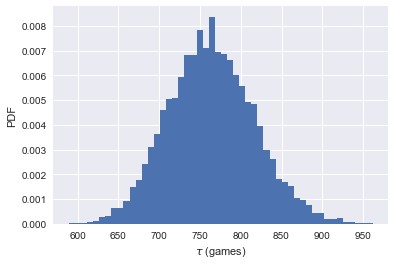

In [76]:
# Draw bootstrap replicates of the mean no-hitter time (equal to tau): bs_replicates
bs_replicates = draw_bs_reps(nohitter_times,np.mean,10000)

# Compute the 95% confidence interval: conf_int
conf_int = np.percentile(bs_replicates,[2.5,97.5])

# Print the confidence interval
print('95% confidence interval =', conf_int, 'games')

# Plot the histogram of the replicates
plt.hist(bs_replicates, bins=50, normed=True)
plt.xlabel(r'$\tau$ (games)')
plt.ylabel('PDF')

# Show the plot
plt.show()


## Generating a pair bootstrap sample 

A function to do pair bootstrap

pairs bootstrap involves resampling pairs of data. Each collection of pairs fit with a line, in this case using np.polyfit(). We do this again and again, getting bootstrap replicates of the parameter values. To have a useful tool for doing pairs bootstrap, you will write a function to perform pairs bootstrap on a set of x,y data.

In [97]:
def draw_bs_pairs_linreg(x, y, size=1):
    """Perform pairs bootstrap for linear regression."""

    # Set up array of indices to sample from: inds
    inds = np.arange(len(x))

    # Initialize replicates: bs_slope_reps, bs_intercept_reps
    bs_slope_reps = np.empty(size)
    bs_intercept_reps = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_inds = np.random.choice(inds, size=len(inds))
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        bs_slope_reps[i], bs_intercept_reps[i] = np.polyfit(bs_x, bs_y, 1)

    return bs_slope_reps, bs_intercept_reps

## Pair bootstrap of literacy and fertility data

Using the function you just wrote, perform pairs bootstrap to plot a histogram describing the estimate of the slope from the illiteracy/fertility data. Also report the 95% confidence interval of the slope. The data is available to you in the NumPy arrays illiteracy and fertility

As a reminder, draw_bs_pairs_linreg() has a function signature of draw_bs_pairs_linreg(x, y, size=1), and it returns two values: bs_slope_reps and bs_intercept_reps.

[ 0.04406065  0.05567724]


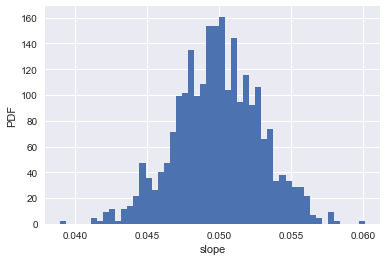

In [99]:
# Generate replicates of slope and intercept using pairs bootstrap
bs_slope_reps, bs_intercept_reps = draw_bs_pairs_linreg(
                    df['illiteracy'], df['fertility'], size=1000)

# Compute and print 95% CI for slope
print(np.percentile(bs_slope_reps, [2.5, 97.5]))

# Plot the histogram
plt.hist(bs_slope_reps, bins=50, normed=True)
plt.xlabel('slope')
plt.ylabel('PDF')
plt.show()

## Plotting Bootstrap regression
A nice way to visualize the variability we might expect in a linear regression is to plot the line you would get from each bootstrap replicate of the slope and intercept. Do this for the first 100 of your bootstrap replicates of the slope and intercept (stored as bs_slope_reps and bs_intercept_reps).

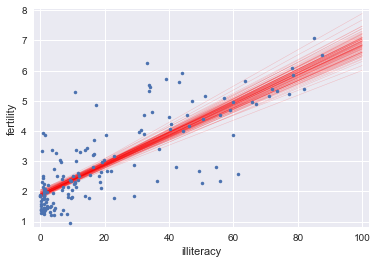

In [100]:
# Generate array of x-values for bootstrap lines: x
x = np.array([0, 100])

# Plot the bootstrap lines
for i in range(100):
    plt.plot(x, 
                 bs_slope_reps[i] * x + bs_intercept_reps[i],
                 linewidth=0.5, alpha=0.2, color='red')

# Plot the data
plt.plot(df['illiteracy'], df['fertility'], marker='.', linestyle='none')

# Label axes, set the margins, and show the plot
plt.xlabel('illiteracy')
plt.ylabel('fertility')
plt.margins(0.02)
plt.show()

## Generating a permutation sample

permutation sampling is a great way to simulate the hypothesis that two variables have identical probability distributions. This is often a hypothesis you want to test, so in this exercise, you will write a function to generate a permutation sample from two data sets.

Remember, a permutation sample of two arrays having respectively n1 and n2 entries is constructed by concatenating the arrays together, scrambling the contents of the concatenated array, and then taking the first n1 entries as the permutation sample of the first array and the last n2 entries as the permutation sample of the second array.

In [101]:
def permutation_sample(data1, data2):
    """Generate a permutation sample from two data sets."""

    # Concatenate the data sets: data
    data = np.concatenate((data1, data2))

    # Permute the concatenated array: permuted_data
    permuted_data = np.random.permutation(data)

    # Split the permuted array into two: perm_sample_1, perm_sample_2
    perm_sample_1 = permuted_data[:len(data1)]
    perm_sample_2 = permuted_data[len(data1):]

    return perm_sample_1, perm_sample_2

## Visualizing permutation sampling

To help see how permutation sampling works, in this exercise you will generate permutation samples and look at them graphically.

We will use the Sheffield Weather Station data again, this time considering the monthly rainfall in July (a dry month) and November (a wet month). We expect these might be differently distributed, so we will take permutation samples to see how their ECDFs would look if they were identically distributed.

The data are stored in the Numpy arrays rain_june and rain_november.

As a reminder, permutation_sample() has a function signature of permutation_sample(data_1, data_2) with a return value of permuted_data[:len(data_1)], permuted_data[len(data_1):], where permuted_data = np.random.permutation(np.concatenate((data_1, data_2)))

In [105]:
rain_july = np.array([  66.2,   39.7,   76.4,   26.5,   11.2,   61.8,    6.1,   48.4,
         89.2,  104. ,   34. ,   60.6,   57.1,   79.1,   90.9,   32.3,
         63.8,   78.2,   27.5,   43.4,   30.1,   17.3,   77.5,   44.9,
         92.2,   39.6,   79.4,   66.1,   53.5,   98.5,   20.8,   55.5,
         39.6,   56. ,   65.1,   14.8,   13.2,   88.1,    8.4,   32.1,
         19.6,   40.4,    2.2,   77.5,  105.4,   77.2,   38. ,   27.1,
        111.8,   17.2,   26.7,   23.3,   77.2,   87.2,   27.7,   50.6,
         60.3,   15.1,    6. ,   29.4,   39.3,   56.3,   80.4,   85.3,
         68.4,   72.5,   13.3,   28.4,   14.7,   37.4,   49.5,   57.2,
         85.9,   82.1,   31.8,  126.6,   30.7,   41.4,   33.9,   13.5,
         99.1,   70.2,   91.8,   61.3,   13.7,   54.9,   62.5,   24.2,
         69.4,   83.1,   44. ,   48.5,   11.9,   16.6,   66.4,   90. ,
         34.9,  132.8,   33.4,  225. ,    7.6,   40.9,   76.5,   48. ,
        140. ,   55.9,   54.1,   46.4,   68.6,   52.2,  108.3,   14.6,
         11.3,   29.8,  130.9,  152.4,   61. ,   46.6,   43.9,   30.9,
        111.1,   68.5,   42.2,    9.8,  285.6,   56.7,  168.2,   41.2,
         47.8,  166.6,   37.8,   45.4,   43.2])

In [106]:
rain_november = np.array([  83.6,   30.9,   62.2,   37. ,   41. ,  160.2,   18.2,  122.4,
         71.3,   44.2,   49.1,   37.6,  114.5,   28.8,   82.5,   71.9,
         50.7,   67.7,  112. ,   63.6,   42.8,   57.2,   99.1,   86.4,
         84.4,   38.1,   17.7,  102.2,  101.3,   58. ,   82. ,  101.4,
         81.4,  100.1,   54.6,   39.6,   57.5,   29.2,   48.8,   37.3,
        115.4,   55.6,   62. ,   95. ,   84.2,  118.1,  153.2,   83.4,
        104.7,   59. ,   46.4,   50. ,  147.6,   76.8,   59.9,  101.8,
        136.6,  173. ,   92.5,   37. ,   59.8,  142.1,    9.9,  158.2,
         72.6,   28. ,  112.9,  119.3,  199.2,   50.7,   44. ,  170.7,
         67.2,   21.4,   61.3,   15.6,  106. ,  116.2,   42.3,   38.5,
        132.5,   40.8,  147.5,   93.9,   71.4,   87.3,  163.7,  141.4,
         62.6,   84.9,   28.8,  121.1,   28.6,   32.4,  112. ,   50. ,
         96.9,   81.8,   70.4,  117.5,   41.2,  124.9,   78.2,   93. ,
         53.5,   50.5,   42.6,   47.9,   73.1,  129.1,   56.9,  103.3,
         60.5,  134.3,   93.1,   49.5,   48.2,  167.9,   27. ,  111.1,
         55.4,   36.2,   57.4,   66.8,   58.3,   60. ,  161.6,  112.7,
         37.4,  110.6,   56.6,   95.8,  126.8])

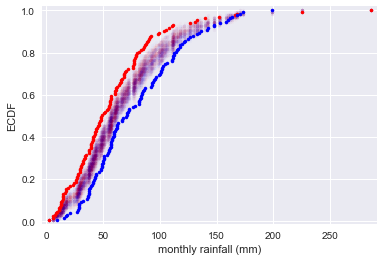

In [107]:
for _ in range(50):
    # Generate permutation samples
    perm_sample_1, perm_sample_2 = permutation_sample(
                                    rain_july, rain_november)

    # Compute ECDFs
    x_1, y_1 = ecdf(perm_sample_1)
    x_2, y_2 = ecdf(perm_sample_2)

    # Plot ECDFs of permutation sample
plt.plot(x_1, y_1, marker='.', linestyle='none',
                 color='red', alpha=0.02)
plt.plot(x_2, y_2, marker='.', linestyle='none',
                 color='blue', alpha=0.02)

# Create and plot ECDFs from original data
x_1, y_1 = ecdf(rain_july)
x_2, y_2 = ecdf(rain_november)
plt.plot(x_1, y_1, marker='.', linestyle='none', color='red')
plt.plot(x_2, y_2, marker='.', linestyle='none', color='blue')

# Label axes, set margin, and show plot
plt.margins(0.02)
plt.xlabel('monthly rainfall (mm)')
plt.ylabel('ECDF')
plt.show()

## Generating permutation replicates

a permutation replicate is a single value of a statistic computed from a permutation sample. As the draw_bs_reps() function you wrote is useful for you to generate bootstrap replicates, it is useful to have a similar function, draw_perm_reps(), to generate permutation replicates.

The function has call signature draw_perm_reps(data_1, data_2, func, size=1). Importantly, func must be a function that takes two arrays as arguments. In most circumstances, func will be a function you write yourself.

In [108]:
def draw_perm_reps(data_1, data_2, func, size=1):
    """Generate multiple permutation replicates."""

    # Initialize array of replicates: perm_replicates
    perm_replicates = np.empty(size)

    for i in range(size):
        # Generate permutation sample
        perm_sample_1, perm_sample_2 = permutation_sample(data_1, data_2)

        # Compute the test statistic
        perm_replicates[i] = func(perm_sample_1, perm_sample_2)

    return perm_replicates

In [112]:
df1 = pd.read_csv("frog_tongue.csv",sep=',')

In [113]:
df1.head()

,date,ID,trial number,impact force (mN),impact time (ms),impact force / body weight,adhesive force (mN),time frog pulls on target (ms),adhesive force / body weight,adhesive impulse (N-s),total contact area (mm2),contact area without mucus (mm2),contact area with mucus / contact area without mucus,contact pressure (Pa),adhesive strength (Pa)
0,2013_02_26,I,3,1205,46,1.95,-785,884,1.27,-0.290,387,70,0.82,3117,-2030
1,2013_02_26,I,4,2527,44,4.08,-983,248,1.59,-0.181,101,94,0.07,24923,-9695
2,2013_03_01,I,1,1745,34,2.82,-850,211,1.37,-0.157,83,79,0.05,21020,-10239
3,2013_03_01,I,2,1556,41,2.51,-455,1025,0.74,-0.170,330,158,0.52,4718,-1381
4,2013_03_01,I,3,493,36,0.80,-974,499,1.57,-0.423,245,216,0.12,2012,-3975


### Look before you leap: EDA before hypothesis testing

Kleinteich and Gorb (Sci. Rep., 4, 5225, 2014) performed an interesting experiment with South American horned frogs. They held a plate connected to a force transducer, along with a bait fly, in front of them. They then measured the impact force and adhesive force of the frog's tongue when it struck the target.

Frog A is an adult and Frog B is a juvenile. The researchers measured the impact force of 20 strikes for each frog. In the next exercise, we will test the hypothesis that the two frogs have the same distribution of impact forces. 

But, remember, it is important to do EDA first! Let's make a bee swarm plot for the data. They are stored in a Pandas data frame, df, where column ID is the identity of the frog and column impact_force is the impact force in Newtons (N).

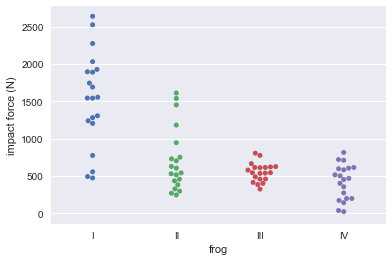

In [115]:
# Make bee swarm plot
sns.swarmplot(x='ID', y='impact force (mN)', data=df1)

# Label axes
plt.xlabel('frog')
plt.ylabel('impact force (N)')

# Show the plot
plt.show()

### Permutation test on frog data

The average strike force of Frog A was 0.71 Newtons (N), and that of Frog B was 0.42 N for a difference of 0.29 N. It is possible the frogs strike with the same force and this observed difference was by chance. You will compute the probability of getting at least a 0.29 N difference in mean strike force under the hypothesis that the distributions of strike forces for the two frogs are identical. We use a permutation test with a test statistic of the difference of means to test this hypothesis.

In [116]:
force_a = np.array([ 1.612,  0.605,  0.327,  0.946,  0.541,  1.539,  0.529,  0.628,
        1.453,  0.297,  0.703,  0.269,  0.751,  0.245,  1.182,  0.515,
        0.435,  0.383,  0.457,  0.73 ])
force_b = np.array([ 0.172,  0.142,  0.037,  0.453,  0.355,  0.022,  0.502,  0.273,
        0.72 ,  0.582,  0.198,  0.198,  0.597,  0.516,  0.815,  0.402,
        0.605,  0.711,  0.614,  0.468])

In [117]:
def diff_of_means(data_1, data_2):
    """Difference in means of two arrays."""

    # The difference of means of data_1, data_2: diff
    diff = np.mean(data_1) - np.mean(data_2)

    return diff

# Compute difference of mean impact force from experiment: empirical_diff_means
empirical_diff_means = diff_of_means(force_a, force_b)

# Draw 10,000 permutation replicates: perm_replicates
perm_replicates = draw_perm_reps(force_a, force_b,
                                 diff_of_means, size=10000)

# Compute p-value: p
p = np.sum(perm_replicates >= empirical_diff_means) / len(perm_replicates)

# Print the result
print('p-value =', p)

p-value = 0.0042


### One simple bootstrap hypothesis test

Another juvenile frog was studied, Frog C, and you want to see if Frog B and Frog C have similar impact forces. Unfortunately, you do not have Frog C's impact forces available, but you know they have a mean of 0.55 N.

Because you don't have the original data, you cannot do a permutation test, and you cannot assess the hypothesis that the forces from Frog B and Frog C come from the same distribution. You will therefore test another, less restrictive hypothesis: 

The mean strike force of Frog B is equal to that of Frog C.

To set up the bootstrap hypothesis test, you will take the mean as our test statistic. Remember, your goal is to calculate the probability of getting a mean impact force less than or equal to what was observed for Frog B if the hypothesis that the true mean of Frog B's impact forces is equal to that of Frog C is true. 

You first translate all of the data of Frog B such that the mean is 0.55 N. This involves adding the mean force of Frog C and subtracting the mean force of Frog B from each measurement of Frog B. 

This leaves other properties of Frog B's distribution, such as the variance, unchanged.

In [118]:
# Make an array of translated impact forces: translated_force_b
translated_force_b = force_b - np.mean(force_b) + 0.55

# Take bootstrap replicates of Frog B's translated impact forces: bs_replicates
bs_replicates = draw_bs_reps(translated_force_b, np.mean, 10000)

# Compute fraction of replicates that are less than the observed Frog B force: p
p = np.sum(bs_replicates <= np.mean(force_b)) / 10000

# Print the p-value
print('p = ', p)


p =  0.0046


### A two-sample bootstrap hypothesis test for difference of means

We now want to test the hypothesis that Frog A and Frog B have the same mean impact force, but not necessarily the same distribution, which is also impossible with a permutation test.

To do the two-sample bootstrap test, we shift both arrays to have the same mean, since we are simulating the hypothesis that their means are, in fact, equal. We then draw bootstrap samples out of the shifted arrays and compute the difference in means. This constitutes a bootstrap replicate, and we generate many of them. 

The p-value is the fraction of replicates with a difference in means greater than or equal to what was observed.

The objects forces_concat and empirical_diff_means are already in your namespace.

In [127]:
forces_concat = np.array([ 1.612,  0.605,  0.327,  0.946,  0.541,  1.539,  0.529,  0.628,
        1.453,  0.297,  0.703,  0.269,  0.751,  0.245,  1.182,  0.515,
        0.435,  0.383,  0.457,  0.73 , 0.172,  0.142,  0.037,  0.453,  0.355,  0.022,  0.502,  0.273,
        0.72 ,  0.582,  0.198,  0.198,  0.597,  0.516,  0.815,  0.402,
        0.605,  0.711,  0.614,  0.468])


In [128]:
# Compute mean of all forces: mean_force
mean_force = np.mean(forces_concat)

# Generate shifted arrays
force_a_shifted = force_a - np.mean(force_a) + mean_force
force_b_shifted = force_b - np.mean(force_b) + mean_force

# Compute 10,000 bootstrap replicates from shifted arrays
bs_replicates_a = draw_bs_reps(force_a_shifted, np.mean, size=10000)
bs_replicates_b = draw_bs_reps(force_b_shifted, np.mean, size=10000)

# Get replicates of difference of means: bs_replicates
bs_replicates = bs_replicates_a - bs_replicates_b

# Compute and print p-value: p
p = np.sum(bs_replicates >= empirical_diff_means) / len(bs_replicates)
print('p-value =', p)


p-value = 0.0042


### The vote for the Civil Rights Act in 1964

The Civil Rights Act of 1964 was one of the most important pieces of legislation ever passed in the USA. Excluding "present" and "abstain" votes, 153 House Democrats and 136 Republicans voted yea. However, 91 Democrats and 35 Republicans voted nay. Did party affiliation make a difference in the vote?

To answer this question, you will evaluate the hypothesis that the party of a House member has no bearing on his or her vote. You will use the fraction of Democrats voting in favor as your test statistic and evaluate the probability of observing a fraction of Democrats voting in favor at least as small as the observed fraction of 153/244. (That's right, at least as small as. In 1964, it was the Democrats who were less progressive on civil rights issues.) 

To do this, permute the party labels of the House voters and then arbitrarily divide them into "Democrats" and "Republicans" and compute the fraction of Democrats voting yea.

In [129]:
# Construct arrays of data: dems, reps
dems = np.array([True] * 153 + [False] * 91)
reps = np.array([True] * 136 + [False] * 35)

def frac_yea_dems(dems, reps):
    """Compute fraction of Democrat yea votes."""
    frac = np.sum(dems) / len(dems)
    return frac

# Acquire permutation samples: perm_replicates
perm_replicates = draw_perm_reps(dems, reps, frac_yea_dems, 10000)

# Compute and print p-value: p
p = np.sum(perm_replicates <= 153/244) / len(perm_replicates)
print('p-value =', p)

p-value = 0.0002


### Hypothesis test on Pearson correlation

The observed correlation between female illiteracy and fertility may just be by chance; the fertility of a given country may actually be totally independent of its illiteracy. You will test this hypothesis. To do so, permute the illiteracy values but leave the fertility values fixed. 

This simulates the hypothesis that they are totally independent of each other. For each permutation, compute the Pearson correlation coefficient and assess how many of your permutation replicates have a Pearson correlation coefficient greater than the observed one.

In [135]:
# Compute observed correlation: r_obs
r_obs = pearsonr(df['illiteracy'], df['fertility'])

# Initialize permutation replicates: perm_replicates
perm_replicates = np.empty(10000)

# Draw replicates
for i in range(10000):
    # Permute illiteracy measurments: illiteracy_permuted
    illiteracy_permuted = np.random.permutation(df['illiteracy'])

    # Compute Pearson correlation
    perm_replicates[i] = pearsonr(illiteracy_permuted, fertility)

# Compute p-value: p
p = np.sum(perm_replicates >= r_obs) / len(perm_replicates)
print('p-val =', p)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()